---
# Food Vision Fine tuning Project
---

## In this project, we will explore the following:
- Fine-tuning as a type of transfer learning to modify a pre-trained model for better adaptation to data.
- Using the Keras Functional API to build models in TensorFlow.
- Experimenting with smaller datasets (e.g., 1-10% of training examples for 10 food classes) for faster iterations.
- Data augmentation techniques to increase diversity in the training set without adding more data.
## Conducting a series of model experiments on our Food Vision data:
- Model 0: Transfer learning using the Keras Functional API.
- Model 1: Feature extraction model via transfer learning on 1% of the data with data augmentation.
- Model 2: Feature extraction model via transfer learning on 10% of the data with data augmentation.
- Model 3: Fine-tuned model via transfer learning on 10% of the data.
- Model 4: Fine-tuned model via transfer learning on 100% of the data.
- ModelCheckpoint callback to save intermediate training results.

In [1]:
from helper_functions import *

In [2]:
!nvidia-smi

Wed Jul 17 11:42:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.70                 Driver Version: 560.70         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   61C    P0             27W /   90W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

### Create training and test directories

In [4]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

### Creating data inputs

In [5]:
import tensorflow as tf

In [6]:
IMG_SHAPE = (224,224)
BATCH_SIZE = 32

In [7]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            image_size = IMG_SHAPE,
                                                                            label_mode ="categorical",
                                                                            batch_size = BATCH_SIZE)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           image_size = IMG_SHAPE,
                                                                           label_mode = "categorical",
                                                                           batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 750 files belonging to 10 classes.


In [8]:
# Check the training data type 
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In the given context:

- (None, 224, 224, 3) refers to the tensor shape of our images, where None represents the batch size, 224 is the height and width of the images, and 3 denotes the color channels (red, green, blue).
- (None, 10) pertains to the tensor shape of the labels, where None denotes the batch size, and 10 indicates the number of possible labels (10 different food classes).
- Both the image tensors and the labels are of type tf.float32.
- None for batch_size is used because it is determined during model training. You can think of None as a placeholder waiting to be filled with the batch_size parameter from image_dataset_from_directory().
- Another advantage of using the tf.data.Dataset API are its associated methods.

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
for images,labels in train_data_10_percent.take(1):
    print(images,labels)

tf.Tensor(
[[[[173.28572   187.28572   188.28572  ]
   [174.28572   188.28572   189.28572  ]
   [176.0051    190.0051    191.0051   ]
   ...
   [ 80.8418     83.8418     76.8418   ]
   [ 86.35714    87.21426    82.2857   ]
   [ 85.19899    83.51015    81.2806   ]]

  [[174.        188.        189.       ]
   [174.        188.        189.       ]
   [174.92857   188.92857   189.92857  ]
   ...
   [ 85.71439    87.11231    80.882744 ]
   [ 86.85713    87.72445    82.724464 ]
   [ 90.78589    89.92875    85.857315 ]]

  [[172.42857   186.42857   187.42857  ]
   [172.42857   186.42857   187.42857  ]
   [172.42857   186.42857   187.42857  ]
   ...
   [ 78.719444   79.719444   72.05619  ]
   [ 85.198975   86.198975   80.21429  ]
   [ 89.438896   90.438896   85.438896 ]]

  ...

  [[124.28061   149.28061   156.28061  ]
   [122.07143   147.07143   154.07143  ]
   [121.214294  146.2143    153.2143   ]
   ...
   [114.214294  113.214294  108.214294 ]
   [115.214294  112.285736  103.07141  ]
   [1

# Model 0: Building a transfer learning model using the Keras Functional API

In [11]:
import tensorflow as tf

In [12]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model 
inputs = tf.keras.layers.Input(shape = (224,224,3), name = "input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_models
x = base_model(inputs)
print(f"Shape after base_model:{x.shape}")

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling")(x)
print(f"After Global Average Pooling 2D: {x.shape}")

# 7. Create the output activation layers
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

# 8. Combine inputs with the outputs layer
model_0 = tf.keras.Model(inputs,outputs)

Shape after base_model:(None, 7, 7, 1280)
After Global Average Pooling 2D: (None, 1280)


## Compile the model

In [13]:
model_0.compile(loss = "categorical_crossentropy",
                optimizer = "Adam",
                metrics = ["accuracy"])

## Fit the model

In [14]:
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data_10_percent,
                                 validation_steps= int(0.25*len(test_data_10_percent)),
                                 callbacks=[create_tensorboard_callback("transfer_learning","10_percent_feature_extract")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20240717-114310
Epoch 1/5
24/24 [==============================] - 14s 132ms/step - loss: 1.9299 - accuracy: 0.3867 - val_loss: 1.3531 - val_accuracy: 0.7396
Epoch 2/5
24/24 [==============================] - 2s 75ms/step - loss: 1.1660 - accuracy: 0.7413 - val_loss: 0.9516 - val_accuracy: 0.7760
Epoch 3/5
24/24 [==============================] - 2s 76ms/step - loss: 0.8468 - accuracy: 0.8173 - val_loss: 0.6627 - val_accuracy: 0.8594
Epoch 4/5
24/24 [==============================] - 2s 80ms/step - loss: 0.6863 - accuracy: 0.8413 - val_loss: 0.5685 - val_accuracy: 0.8750
Epoch 5/5
24/24 [==============================] - 2s 81ms/step - loss: 0.5874 - accuracy: 0.8733 - val_loss: 0.4950 - val_accuracy: 0.8958


### Check layers in base model

In [15]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer)

0 <keras.engine.input_layer.InputLayer object at 0x000001F33024F400>
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x000001F3471FCCA0>
2 <keras.layers.preprocessing.normalization.Normalization object at 0x000001F3471FDD50>
3 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001F3471FDDB0>
4 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001F3471FE4A0>
5 <keras.layers.core.activation.Activation object at 0x000001F32DB169E0>
6 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001F361AF9030>
7 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001F361AF94B0>
8 <keras.layers.core.activation.Activation object at 0x000001F361AF9180>
9 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001F361AF9C60>
10 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001F361AFB340>
11 <keras.layers.core.activation.Activation object at 0x000001F361AFAFE0>
12 <keras.lay

In [16]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                                

Each of the layers in the model has a specific number of parameters. Since we are using a pretrained model, you can think of these parameters as templates that the base model learned from another dataset. Because we set base_model.trainable = False, these templates remain unchanged during training—they are frozen and not updated.

In [17]:
# Model_0 summary
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


- Our entire model comprises 5 layers, but one of these layers (efficientnetv2-b0) contains 269 layers itself.

- You can observe how the output shape started as (None, 224, 224, 3) for the input layer (the shape of our images), but was transformed to (None, 10) by the output layer (the shape of our labels), where None serves as a placeholder for the batch size.

- The only trainable parameters in the model are those in the output layer.

## Check training curves

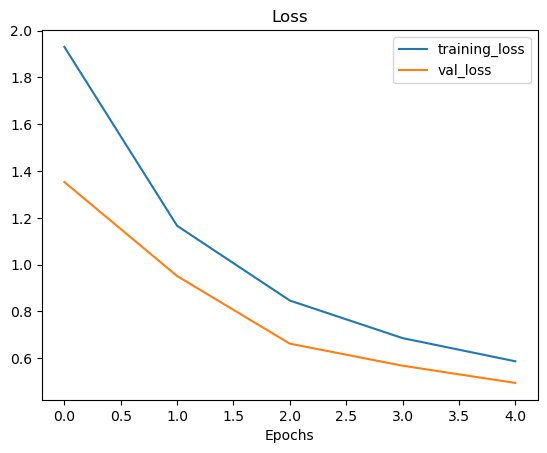

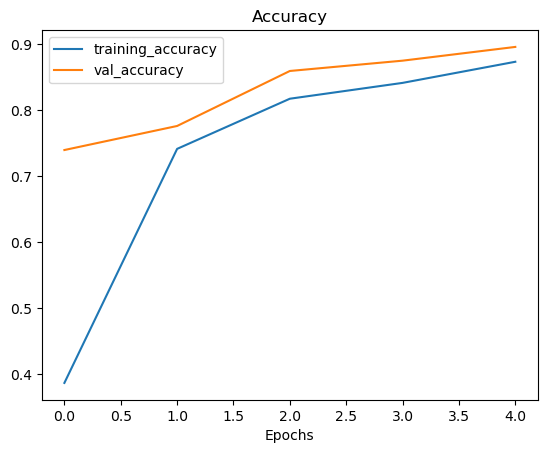

In [18]:
plot_loss_curves(history_10_percent)

# Running a series of transfer learning experiments

- **Model 1**: Use feature extraction transfer learning on 1% of the training data with **data augmentation**.
- **Model 2**: Use feature extraction transfer learning on 10% of the training data with **data augmentation** and save the results to a **checkpoint**.
- **Model 3**: Fine-tune the Model 2 checkpoint on 10% of the training data with **data augmentation**.
- **Model 4**: Fine-tune the Model 2 checkpoint on 100% of the training data with **data augmentation**.

## Model 1 (1% of the training data with data augmentation)

### Create training and test directories

In [19]:
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir_1_percent = "10_food_classes_1_percent/test/"

In [20]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

### Creating data inputs

In [21]:
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                         image_size = IMG_SHAPE,
                                                                         batch_size = BATCH_SIZE,
                                                                         label_mode = "categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size = IMG_SHAPE,
                                                                batch_size = BATCH_SIZE,
                                                                label_mode = "categorical")

Found 70 files belonging to 10 classes.
Found 750 files belonging to 10 classes.


## Adding data augmentation right into the model

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

## View random image

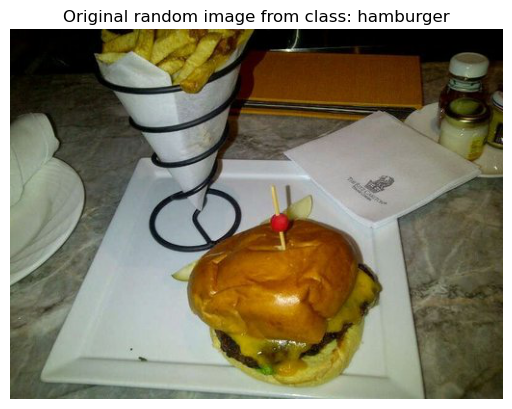

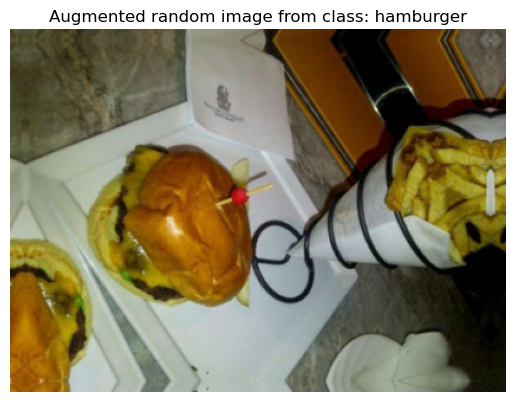

In [23]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

tf.get_logger().setLevel('ERROR')

target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0),training=True) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## 1. Creating model_1

In [24]:
# Setup and intput shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable = False

# Create layers
inputs = layers.Input(shape = input_shape, name = "input_layer")

# Add in data augmentation sequential as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x,training = False)

# Pool the output features of the base model
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

# Create a model with inputs and outputs
model_1 = tf.keras.Model(inputs,outputs)

## 2. Compile model_1

In [25]:
model_1.compile(loss ="categorical_crossentropy",
                optimizer = "Adam",
                metrics = ["accuracy"])

## 3. Fit the model

In [26]:
history_1 = model_1.fit(train_data_1_percent,
                        epochs = 5,
                        steps_per_epoch = len(train_data_1_percent),
                        validation_data = test_data,
                        validation_steps = int(0.25*len(test_data)),
                        callbacks = [create_tensorboard_callback("transfer_learning",
                                                                 "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240717-114446
Epoch 1/5
3/3 [==============================] - 10s 1s/step - loss: 2.4645 - accuracy: 0.1000 - val_loss: 2.2282 - val_accuracy: 0.1615
Epoch 2/5
3/3 [==============================] - 1s 412ms/step - loss: 2.2306 - accuracy: 0.1429 - val_loss: 2.1611 - val_accuracy: 0.2292
Epoch 3/5
3/3 [==============================] - 1s 417ms/step - loss: 2.0470 - accuracy: 0.3429 - val_loss: 2.0438 - val_accuracy: 0.3021
Epoch 4/5
3/3 [==============================] - 1s 403ms/step - loss: 1.8325 - accuracy: 0.4857 - val_loss: 1.9484 - val_accuracy: 0.3698
Epoch 5/5
3/3 [==============================] - 1s 380ms/step - loss: 1.7319 - accuracy: 0.6000 - val_loss: 1.8307 - val_accuracy: 0.4115


In [27]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

# Evaluate on the full test data

In [28]:
# Evaluate on the test data
result_1_percent_data = model_1.evaluate(test_data)
result_1_percent_data

24/24 [==============================] - 2s 52ms/step - loss: 1.8382 - accuracy: 0.4560


[1.8382412195205688, 0.4560000002384186]

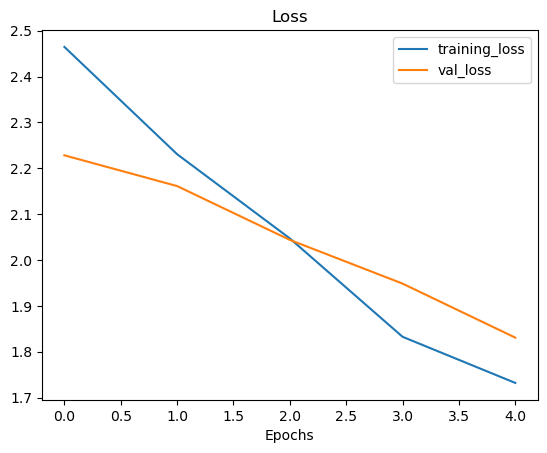

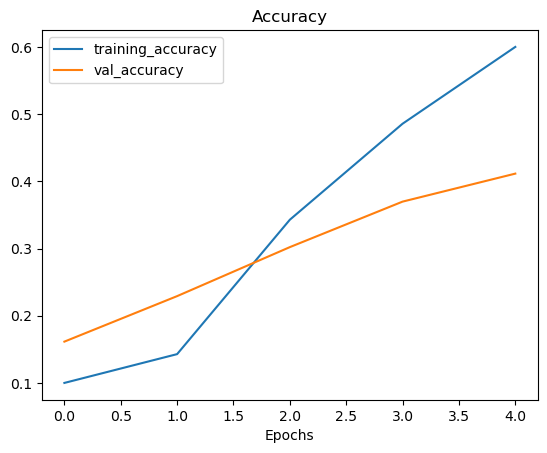

In [30]:
plot_loss_curves(history_1)

# Model 2 (10% of data with data augmentation)

In [31]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

## Set up the data

In [32]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            image_size = IMG_SHAPE,
                                                                            label_mode = "categorical")
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           image_size = IMG_SHAPE,
                                                                           label_mode = "categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## 1. Creating the model

In [33]:
# Create a frozen base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Creating inputs layers
inputs = layers.Input(shape = input_shape, name = "input layer")
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layers")(x)
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)
model_2 = keras.Model(inputs,outputs)

## 2. Compile the model

In [34]:
model_2.compile(loss = "categorical_crossentropy",
                optimizer = "Adam",
                metrics=["accuracy"])

## Creating checkpoint callbacks

In [35]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     save_best_only=True,
                                                     save_freq="epoch",
                                                     verbose=1)

## 3. Fit the model

In [36]:
history_10_percent_data = model_2.fit(train_data_10_percent,
                                      epochs = 5,
                                      validation_data= test_data,
                                      validation_steps=int(0.25*len(test_data)),
                                      callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240717-114712
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0844 - accuracy: 0.2840
Epoch 1: val_loss improved from inf to 1.57302, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 15s 329ms/step - loss: 2.0844 - accuracy: 0.2840 - val_loss: 1.5730 - val_accuracy: 0.6719
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4259 - accuracy: 0.6587
Epoch 2: val_loss improved from 1.57302 to 1.10533, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 6s 259ms/step - loss: 1.4259 - accuracy: 0.6587 - val_loss: 1.1053 - val_accuracy: 0.7500
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1302 - accuracy: 0.7200
Epoch 3: val_loss improved from 1.10533 to 0.88405, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==

# Evaluate the model

In [37]:
result_10_percent_data = model_2.evaluate(test_data_10_percent)
result_10_percent_data

79/79 [==============================] - 5s 55ms/step - loss: 0.6565 - accuracy: 0.8420


[0.6565155982971191, 0.8420000076293945]

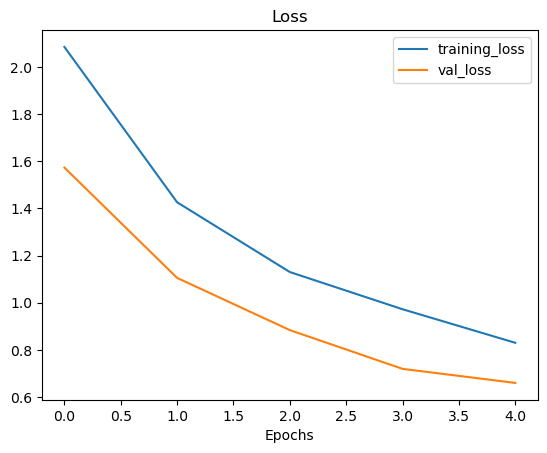

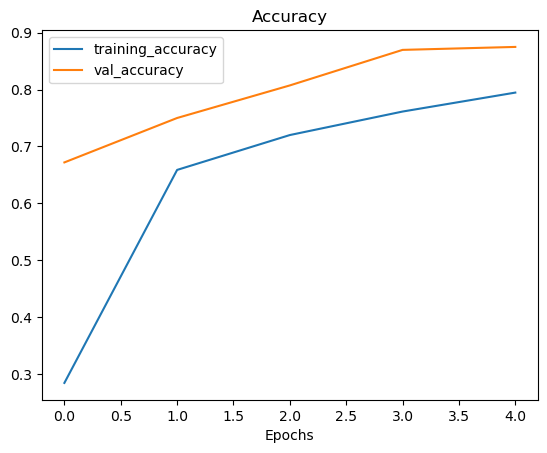

In [38]:
plot_loss_curves(history_10_percent_data)

According to these results, the performance of our model with 10% of the data and data augmentation is not as good as the model using 10% of the data without augmentation (refer to the results of Model 0 above). However, the curves show a positive trend, indicating that if we continue training for longer, its metrics are likely to improve.

### Load in save model weights and evalaute model

In [40]:
model_2.load_weights(checkpoint_path)
loaded_weights_result = model_2.evaluate(test_data)

24/24 [==============================] - 2s 53ms/step - loss: 0.6385 - accuracy: 0.8667


### Are the results from the native model and the loaded weights the same?

In [45]:
result_10_percent_data == loaded_weights_result

False

In [47]:
import numpy as np
np.isclose(np.array(result_10_percent_data), np.array(loaded_weights_result))

array([False, False])

### The difference between the two results (small values)

In [51]:
print(np.array(result_10_percent_data) - np.array(loaded_weights_result))

[ 0.01796585 -0.02466667]


# Model 3: Fine-tuning an existing model on 10% of the data

### Layrs in loaded model

In [52]:
model_2.layers

### Check their names, numbers and if they are trainable?

In [53]:
for layer_number, layer in enumerate(model_2.layers):
    print(f"Layer_number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable: {layer.trainable}")

Layer_number: 0 | Layer name: input layer | Layer type: <keras.engine.input_layer.InputLayer object at 0x000001F535E09090> | Trainable: True
Layer_number: 1 | Layer name: data_augmentation | Layer type: <keras.engine.sequential.Sequential object at 0x000001F517417790> | Trainable: True
Layer_number: 2 | Layer name: efficientnetv2-b0 | Layer type: <keras.engine.functional.Functional object at 0x000001F535F26EC0> | Trainable: False
Layer_number: 3 | Layer name: global_average_pooling_layers | Layer type: <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000001F330215F90> | Trainable: True
Layer_number: 4 | Layer name: output_layer | Layer type: <keras.layers.core.dense.Dense object at 0x000001F53609E5F0> | Trainable: True


In [54]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 rs (GlobalAveragePooling2D)                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

## Access the base_model layer of model_2

In [55]:
model_2_base_model = model_2.layers[2]
model_2_base_model.name

'efficientnetv2-b0'

In [56]:
### How many layers are trainable in model_2_base_model
print(len(model_2_base_model.trainable_variables))

0


## Make all layers trainable

In [57]:
model_2_base_model.trainable = True

### Freeze all layers except for the last 10

In [58]:
for layer in model_2_base_model.layers[:-10]:
    layer.trainable = False

### Recompile the whole model (always recompile after any adjustments to a model)

In [59]:
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # lr is 10x slower than before for fine-tuned
                metrics = ["accuracy"])

In [60]:
for layer_number, layer in enumerate(model_2_base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [62]:
print(len(model_2.trainable_variables))

12


In [64]:
initial_epochs = 5
fine_tuned_epochs = initial_epochs + 5

In [65]:
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs= fine_tuned_epochs,
                                               validation_data= test_data,
                                               initial_epoch= history_10_percent_data.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25*len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240717-121019
Epoch 5/10
24/24 [==============================] - 14s 291ms/step - loss: 0.7319 - accuracy: 0.7907 - val_loss: 0.5575 - val_accuracy: 0.8646
Epoch 6/10
24/24 [==============================] - 6s 231ms/step - loss: 0.5891 - accuracy: 0.8267 - val_loss: 0.4726 - val_accuracy: 0.8750
Epoch 7/10
24/24 [==============================] - 6s 248ms/step - loss: 0.5126 - accuracy: 0.8387 - val_loss: 0.4314 - val_accuracy: 0.8854
Epoch 8/10
24/24 [==============================] - 6s 241ms/step - loss: 0.5173 - accuracy: 0.8360 - val_loss: 0.3998 - val_accuracy: 0.8802
Epoch 9/10
24/24 [==============================] - 6s 248ms/step - loss: 0.4688 - accuracy: 0.8627 - val_loss: 0.3955 - val_accuracy: 0.8906
Epoch 10/10
24/24 [==============================] - 6s 231ms/step - loss: 0.4467 - accuracy: 0.8493 - val_loss: 0.4298 - val_accuracy: 0.9010


## Evaluate the model on the test data

In [66]:
result_fine_tune_10_percent = model_2.evaluate(test_data)
result_fine_tune_10_percent

24/24 [==============================] - 2s 53ms/step - loss: 0.3563 - accuracy: 0.8947


[0.35628026723861694, 0.8946666717529297]

The results from evaluating the model might differ slightly from the training outputs because, during training, we only evaluate on 25% of the test data.

## Evaluate the model before and after fine-tuning

In [73]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.2840000092983246, 0.6586666703224182, 0.7200000286102295, 0.7613333463668823, 0.7946666479110718, 0.7906666398048401, 0.8266666531562805, 0.8386666774749756, 0.8360000252723694, 0.862666666507721, 0.8493333458900452]


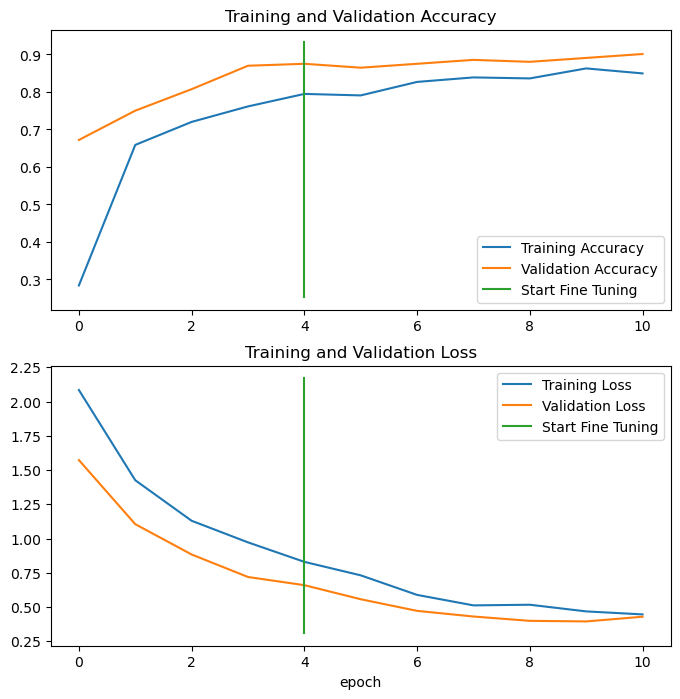

In [75]:
compare_historys(original_history=history_10_percent_data,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

It looks like the curves are heading in the right direction after fine-tuning. However, keep in mind that fine-tuning typically yields the best results with larger datasets.

# Model 4: Fine-tuning an existing model all of the data

In [76]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [77]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

# Set up data inputs

In [78]:
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode = "categorical",
                                                                                 image_size= IMG_SHAPE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode= "categorical",
                                                                image_size= IMG_SHAPE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Evaluate model (this is the fine-tuned 10 percent of data version)

In [79]:
model_2.evaluate(test_data)

79/79 [==============================] - 5s 59ms/step - loss: 0.4296 - accuracy: 0.8616


[0.42956358194351196, 0.8615999817848206]

In [80]:
result_fine_tune_10_percent

[0.35628026723861694, 0.8946666717529297]

To maintain the integrity of our experiments, we'll create a new instance of `model_2` using our `create_base_model()` function.

Specifically, we aim to measure:

- **Experiment 3** (previous one): model_2 with 10 layers fine-tuned for 5 additional epochs on 10% of the data.
- **Experiment 4** (current one): model_2 with layers fine-tuned for 5 additional epochs on 100% of the data.

It's crucial that both experiments use the same test data to ensure consistent evaluation. Additionally, they should start from the same checkpoint (`model_2 feature extractor` trained for 5 epochs on 10% of the data).

Let's first create a new instance of `model_2`.

In [81]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create a new instance of model_2 for Experiment 4

In [82]:
model_2 = create_base_model(learning_rate=0.0001)

In [83]:
model_2.load_weights(checkpoint_path)

In [84]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [85]:
model_2.evaluate(test_data)

79/79 [==============================] - 7s 55ms/step - loss: 0.6565 - accuracy: 0.8420


[0.6565154194831848, 0.8420000076293945]

We have:

- Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint (Model 2).
- Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (Model 3).
- Reloaded the model from step 1 to do the same steps as step 2 but with all (100%) of the data (Model 4).

We're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs.

In [87]:
for layers_number, layer in enumerate(model_2.layers):
    print(layers_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


## Unfreeze the top 10 layers in model_2 base model

In [88]:
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

In [89]:
for layer in model_2_base_model.layers[:-10]:
    layer.trainable = False

In [90]:
for layer_number, layer in enumerate(model_2_base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

**The last 10 layers are trainable (unfrozen).**

In [92]:
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                metrics = ["accuracy"])

### Fit the model

In [97]:
# Continue to train and fine-tune the model to our data
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20240717-125557
Epoch 5/10
235/235 [==============================] - 53s 222ms/step - loss: 0.5355 - accuracy: 0.8253 - val_loss: 0.2960 - val_accuracy: 0.8931
Epoch 6/10
235/235 [==============================] - 54s 230ms/step - loss: 0.4787 - accuracy: 0.8436 - val_loss: 0.2762 - val_accuracy: 0.8980
Epoch 7/10
235/235 [==============================] - 54s 229ms/step - loss: 0.4687 - accuracy: 0.8475 - val_loss: 0.2748 - val_accuracy: 0.8931
Epoch 8/10
235/235 [==============================] - 54s 230ms/step - loss: 0.4539 - accuracy: 0.8507 - val_loss: 0.2871 - val_accuracy: 0.8865
Epoch 9/10
235/235 [==============================] - 53s 227ms/step - loss: 0.4271 - accuracy: 0.8593 - val_loss: 0.2478 - val_accuracy: 0.9030
Epoch 10/10
235/235 [==============================] - 53s 226ms/step - loss: 0.4017 - accuracy: 0.8669 - val_loss: 0.2754 - val_accuracy: 0.8931


In [98]:
result_full_data_fine_tuned = model_2.evaluate(test_data)
result_full_data_fine_tuned

79/79 [==============================] - 5s 55ms/step - loss: 0.2502 - accuracy: 0.9140


[0.25017356872558594, 0.9139999747276306]

## Compare history

5
11
[0.2840000092983246, 0.6586666703224182, 0.7200000286102295, 0.7613333463668823, 0.7946666479110718, 0.8253333568572998, 0.8435999751091003, 0.8474666476249695, 0.8506666421890259, 0.859333336353302, 0.8669333457946777]


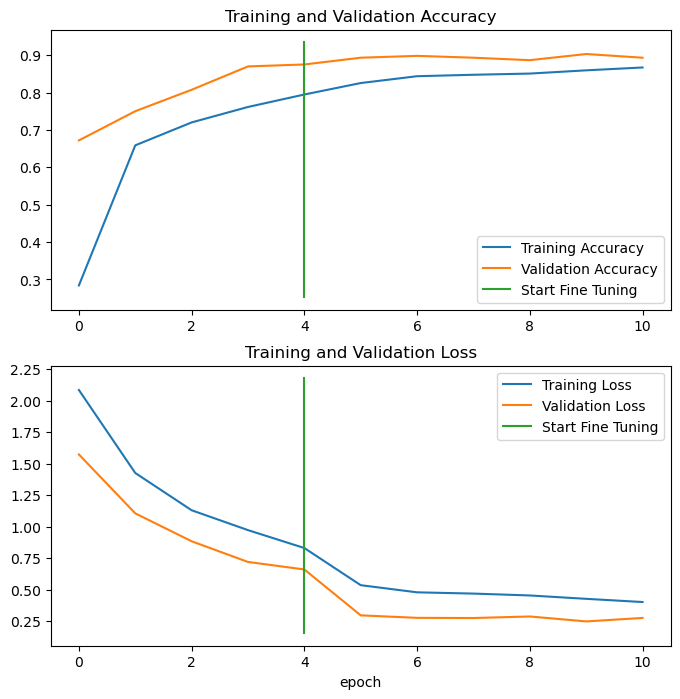

In [99]:
compare_historys(original_history=history_10_percent_data, new_history=history_fine_10_classes_full, initial_epochs=5)

Looks like that extra data helped! Those curves are looking great. And if we trained for longer, they might even keep improving.